In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../../../../")

from data_pipeline.score import field_names
from data_pipeline.comparison_tool.src import utils

pd.options.display.float_format = "{:,.3f}".format
%load_ext lab_black

# Comparator definition comparison

This notebook answers a few questions:
1. How many tracts are flagged and what's the size of overlap by comparator?
2. What are the demographics of each set of tracts by "category" of score (CEJST but not comparator, comparator but not CEJST, CEJST and comparator)?
3. What are the overall demographics of ALL comparator vs ALL CEJST?

It produces a single Excel file of the stats listed, but is interactive even after run-time. This notebook focuses on 1:1 comparison. It can be pointed in the YAML to either a simple output (tract and boolean for highlight) or to the output from an ETL.

In [2]:
## These are parameters and get overridden by the "injected parameters" cell below
ADDITIONAL_DEMO_COLUMNS = []
COMPARATOR_COLUMN = None
COMPARATOR_FILE = None
DEMOGRAPHIC_COLUMNS = []
DEMOGRAPHIC_FILE = None
OUTPUT_DATA_PATH = None
SCORE_FILE = None
OTHER_COMPARATOR_COLUMNS = None
OUTPUT_NAME = None
KEEP_MISSING_VALUES_FOR_SEGMENTATION = True

In [3]:
# Parameters
ADDITIONAL_DEMO_COLUMNS = [
    "Urban Heuristic Flag",
    "Percent of individuals below 200% Federal Poverty Line",
    "Percent individuals age 25 or over with less than high school degree",
    "Unemployment (percent)",
    "Percent of households in linguistic isolation",
]
COMPARATOR_COLUMN = "three_factor_dac"
COMPARATOR_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/data/community_resilience_estimates/clean/cre_clean.csv"
DEMOGRAPHIC_COLUMNS = [
    "Percent Black or African American alone",
    "Percent American Indian and Alaska Native alone",
    "Percent Asian alone",
    "Percent Native Hawaiian and Other Pacific alone",
    "Percent Two or more races",
    "Percent Non-Hispanic White",
    "Percent Hispanic or Latino",
]
DEMOGRAPHIC_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/dataset/census_acs_2019/usa.csv"
OUTPUT_DATA_PATH = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/output/cre"
SCORE_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/score/csv/full/usa.csv"
KEEP_MISSING_VALUES_FOR_SEGMENTATION = True
OTHER_COMPARATOR_COLUMNS = ["one_two_factor_dac", "PRED3_PE", "PRED12_PE"]
OUTPUT_NAME = "cre"

In [4]:
## These are constants for all runs
GEOID_COLUMN = field_names.GEOID_TRACT_FIELD
SCORE_COLUMN = field_names.SCORE_M_COMMUNITIES
TOTAL_POPULATION_COLUMN = field_names.TOTAL_POP_FIELD

__Date and time of last run__

In [5]:
datetime.datetime.now()

datetime.datetime(2022, 3, 30, 18, 11, 22, 701775)

__Congfigure output (autocreated)__

In [6]:
OUTPUT_EXCEL = os.path.join(
    OUTPUT_DATA_PATH,
    f"{OUTPUT_NAME}__{datetime.datetime.now().strftime('%Y-%m-%d')}.xlsx",
)

__Validate new data__

In [7]:
utils.validate_new_data(file_path=COMPARATOR_FILE, score_col=COMPARATOR_COLUMN)

__Read in data__

In [8]:
comparator_cols = (
    [COMPARATOR_COLUMN] + OTHER_COMPARATOR_COLUMNS
    if OTHER_COMPARATOR_COLUMNS
    else [COMPARATOR_COLUMN]
)

# papermill_description=Loading_data
joined_df = pd.concat(
    [
        utils.read_file(
            file_path=SCORE_FILE,
            columns=[TOTAL_POPULATION_COLUMN, SCORE_COLUMN] + ADDITIONAL_DEMO_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
        utils.read_file(
            file_path=COMPARATOR_FILE, columns=comparator_cols, geoid=GEOID_COLUMN
        ),
        utils.read_file(
            file_path=DEMOGRAPHIC_FILE,
            columns=DEMOGRAPHIC_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
    ],
    axis=1,
).reset_index()

## High-level summary

What *shares* of tracts and population highlighted by the comparator are covered by CEJST?

In [9]:
# papermill_description=Summary_stats
population_df = utils.produce_summary_stats(
    joined_df=joined_df,
    comparator_column=COMPARATOR_COLUMN,
    score_column=SCORE_COLUMN,
    population_column=TOTAL_POPULATION_COLUMN,
    geoid_column=GEOID_COLUMN,
)
population_df

Population  Count of tracts  \
three_factor_dac Definition M (communities)                                    
False            False                      202,342,753.000            42890   
                 True                        35,275,812.000             8254   
True             False                       30,247,537.000             7563   
                 True                        55,036,928.000            14349   
missing          False                          200,672.000              230   
                 True                         3,186,269.000              874   

                                             Share of tracts  \
three_factor_dac Definition M (communities)                    
False            False                                 0.578   
                 True                                  0.111   
True             False                                 0.102   
                 True                                  0.193   
missing          False                                 0.003   
                 True                                  0.012   

                                             Share of population  
three_factor_dac Definition M (communities)                       
False            False                                     0.620  
                 True                                      0.108  
True             False                                     0.093  
                 True                                      0.169  
missing          False                                     0.001  
                 True                                      0.010

## Tract-level stats

First, this walks through overall stats for disadvantaged communities under the comparator definition and under the CEJST's definition. Next, this walks through stats by group (e.g., CEJST and not comparator). This is at the tract level, so the average across tracts, where tracts are not population-weighted. 

In [10]:
# papermill_description=Tract_stats
tract_level_by_identification_df = pd.concat(
    [
        utils.get_demo_series(
            grouping_column=COMPARATOR_COLUMN,
            joined_df=joined_df,
            demo_columns=ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
        ),
        utils.get_demo_series(
            grouping_column=SCORE_COLUMN,
            joined_df=joined_df,
            demo_columns=ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
        ),
    ],
    axis=1,
)

tract_level_by_identification_df

,three_factor_dac,Definition M (communities)
Urban Heuristic Flag,0.788,0.839
Percent of individuals below 200% Federal Poverty Line,0.479,0.530
Percent individuals age 25 or over with less than high school degree,0.197,0.225
Unemployment (percent),0.082,0.091
Percent of households in linguistic isolation,0.073,0.112
Percent Black or African American alone,0.249,0.250
Percent American Indian and Alaska Native alone,0.017,0.016
Percent Asian alone,0.036,0.040
Percent Native Hawaiian and Other Pacific alone,0.001,0.002
Percent Two or more races,0.031,0.034


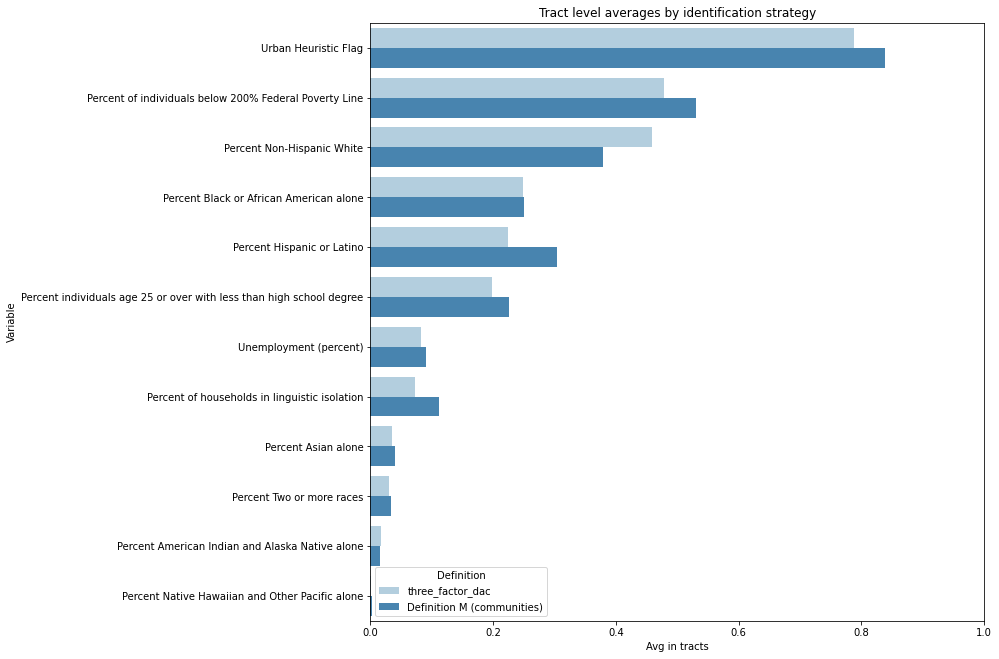

In [11]:
plt.figure(figsize=(11, 11))
sns.barplot(
    y="Variable",
    x="Avg in tracts",
    hue="Definition",
    data=tract_level_by_identification_df.sort_values(
        by=COMPARATOR_COLUMN, ascending=False
    )
    .stack()
    .reset_index()
    .rename(
        columns={"level_0": "Variable", "level_1": "Definition", 0: "Avg in tracts"}
    ),
    palette="Blues",
)
plt.xlim(0, 1)
plt.title("Tract level averages by identification strategy")
plt.savefig(os.path.join(OUTPUT_DATA_PATH, "tract_lvl_avg.jpg"), bbox_inches="tight")

In [12]:
# papermill_description=Tract_stats_grouped
tract_level_by_grouping_df = utils.get_tract_level_grouping(
    joined_df=joined_df,
    score_column=SCORE_COLUMN,
    comparator_column=COMPARATOR_COLUMN,
    demo_columns=ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
    keep_missing_values=KEEP_MISSING_VALUES_FOR_SEGMENTATION,
)

tract_level_by_grouping_formatted_df = utils.format_multi_index_for_excel(
    df=tract_level_by_grouping_df
)

In [13]:
tract_level_by_grouping_formatted_df

,Variable,"Not CEJST, Not Comparator","Not CEJST, Comparator","Not CEJST, No Comparator classification","CEJST, Not Comparator","CEJST, Comparator","CEJST, No Comparator classification"
0,Urban Heuristic Flag,0.804,0.713,0.600,0.858,0.828,NaN
1,Percent of individuals below 200% Federal Pove...,0.222,0.332,0.466,0.466,0.554,0.756
2,Percent individuals age 25 or over with less t...,0.076,0.117,0.087,0.200,0.239,0.252
3,Unemployment (percent),0.043,0.055,0.109,0.074,0.096,0.181
4,Percent of households in linguistic isolation,0.025,0.032,0.239,0.083,0.095,0.708
5,Percent Black or African American alone,0.077,0.138,0.078,0.166,0.306,0.120
6,Percent American Indian and Alaska Native alone,0.006,0.009,0.002,0.010,0.020,0.002
7,Percent Asian alone,0.057,0.039,0.007,0.054,0.034,0.002
8,Percent Native Hawaiian and Other Pacific alone,0.002,0.001,0.000,0.003,0.001,0.000
9,Percent Two or more races,0.033,0.029,0.049,0.036,0.031,0.056


## Population-weighted stats

In [14]:
# papermill_description=Population_stats
population_weighted_stats_df = pd.concat(
    [
        utils.construct_weighted_statistics(
            input_df=joined_df,
            weighting_column=COMPARATOR_COLUMN,
            demographic_columns=DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            population_column=TOTAL_POPULATION_COLUMN,
        ),
        utils.construct_weighted_statistics(
            input_df=joined_df,
            weighting_column=SCORE_COLUMN,
            demographic_columns=DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            population_column=TOTAL_POPULATION_COLUMN,
        ),
    ],
    axis=1,
)

In [15]:
population_weighted_stats_df

,not three_factor_dac,three_factor_dac,not Definition M (communities),Definition M (communities)
Percent Black or African American alone,0.093,0.223,0.089,0.223
Percent American Indian and Alaska Native alone,0.006,0.016,0.006,0.015
Percent Asian alone,0.061,0.039,0.059,0.044
Percent Native Hawaiian and Other Pacific alone,0.002,0.002,0.002,0.002
Percent Two or more races,0.034,0.031,0.033,0.034
Percent Non-Hispanic White,0.663,0.449,0.696,0.362
Percent Hispanic or Latino,0.152,0.258,0.126,0.345
Urban Heuristic Flag,0.839,0.801,0.819,0.823
Percent of individuals below 200% Federal Poverty Line,0.254,0.470,0.233,0.520
Percent individuals age 25 or over with less than high school degree,0.096,0.203,0.082,0.232


## Final information about overlap

In [16]:
comparator_and_cejst_proportion_series, states = utils.get_final_summary_info(
    population=population_df, comparator_file=COMPARATOR_FILE, geoid_col=GEOID_COLUMN
)

In [17]:
comparator_and_cejst_proportion_series

Population            0.645
Count of tracts       0.655
Share of tracts       0.655
Share of population   0.645
dtype: float64

In [18]:
states_text = "States included in comparator: " + states
states_text

'States included in comparator: AL, AK, AZ, AR, CA, CO, CT, DE, DC, FL, GA, HI, ID, IL, IN, IA, KS, KY, LA, ME, MD, MA, MI, MN, MS, MO, MT, NE, NV, NH, NJ, NM, NY, NC, ND, OH, OK, OR, PA, RI, SC, SD, TN, TX, UT, VT, VA, WA, WV, WI, WY'

## Print to excel

In [19]:
# papermill_description=Writing_excel
utils.write_single_comparison_excel(
    output_excel=OUTPUT_EXCEL,
    population_df=population_df,
    tract_level_by_identification_df=tract_level_by_identification_df,
    population_weighted_stats_df=population_weighted_stats_df,
    tract_level_by_grouping_formatted_df=tract_level_by_grouping_formatted_df,
    comparator_and_cejst_proportion_series=comparator_and_cejst_proportion_series,
    states_text=states_text,
)

## Some scratch

In [20]:
joined_df.groupby("one_two_factor_dac")["Definition M (communities)"].value_counts(
    dropna=False
)

one_two_factor_dac  Definition M (communities)
False               False                         36955
                    True                          14191
True                False                         13498
                    True                           8412
Name: Definition M (communities), dtype: int64

In [21]:
joined_df.groupby("three_factor_dac")["Definition M (communities)"].value_counts(
    dropna=False
)

three_factor_dac  Definition M (communities)
False             False                         42890
                  True                           8254
True              True                          14349
                  False                          7563
Name: Definition M (communities), dtype: int64

In [22]:
joined_df.groupby("three_factor_dac")["PRED3_PE"].min(), joined_df.groupby(
    "three_factor_dac"
)["PRED3_PE"].max()

(three_factor_dac
 False    0.000
 True    26.510
 Name: PRED3_PE, dtype: float64,
 three_factor_dac
 False    26.500
 True    100.000
 Name: PRED3_PE, dtype: float64)

three matches better than one-two, only at the top of the distribution

In [23]:
joined_df["top_10_three"] = joined_df["PRED3_PE"].rank(pct=True) >= 0.9

In [24]:
joined_df.groupby("top_10_three")["Definition M (communities)"].value_counts(
    dropna=False
)

top_10_three  Definition M (communities)
False         False                         49476
              True                          17373
True          True                           6104
              False                          1207
Name: Definition M (communities), dtype: int64

In [25]:
joined_df["top_10_one_two"] = joined_df["PRED12_PE"].rank(pct=True) >= 0.9

In [26]:
joined_df.groupby("top_10_one_two")["Definition M (communities)"].value_counts(
    dropna=False
)

top_10_one_two  Definition M (communities)
False           False                         46705
                True                          20154
True            False                          3978
                True                           3323
Name: Definition M (communities), dtype: int64